In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import h5ify 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import importlib
import json

import sys
sys.path.append('/mnt/home/smiller/src/time-domain-gw-inference/')
from time_domain_gw_inference import group_postprocess, utils, run_sampler

importlib.reload(group_postprocess)
importlib.reload(run_sampler)

<module 'time_domain_gw_inference.run_sampler' from '/mnt/home/smiller/src/time-domain-gw-inference/time_domain_gw_inference/run_sampler.py'>

### Load likelihood manager

In [2]:
 # Get likelihood manager
data = group_postprocess.load_run_settings_from_directory('./output/250620_output', filename_dict={'full':'full_0.0seconds'})
lm = data['runs']['full']['likelihood_manager']

key: full
line is /mnt/home/smiller/src/time-domain-gw-inference/time_domain_gw_inference/run_sampler.py --output-h5 full_0.0seconds/full_0.0seconds.h5 --mode full --Tcut-seconds 0.0 --ifos H1 L1 V1 --total-mass-prior-bounds 25 900 --mass-ratio-prior-bounds 0.05 1 --time-prior-sigma 0.02 --luminosity-distance-prior-bounds 500 20000 --approx IMRPhenomXPHM --ncpu 128 --nsteps 50000 --Tstart 1265235994.90607 --Tend 1265235996.20607 --sampling-rate 4096 --f22-start 20 --fref 20 --flow 20 --fmax 1792 --vary-skypos  --vary-time  --resume  --pe-posterior-h5-file data_directory/IGWN-GWTC3p0-v1-GW200208_222617_PEDataRelease_mixed_cosmo.h5 --data H1:data_directory/H1_strain.h5 --data L1:data_directory/L1_strain.h5 --data V1:data_directory/V1_strain.h5 --psd H1:data_directory/H1-psd.dat --psd L1:data_directory/L1-psd.dat --psd V1:data_directory/V1-psd.dat  &>> full_0.0seconds/full_0.0seconds.log

Using L1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in

### Plot PSD

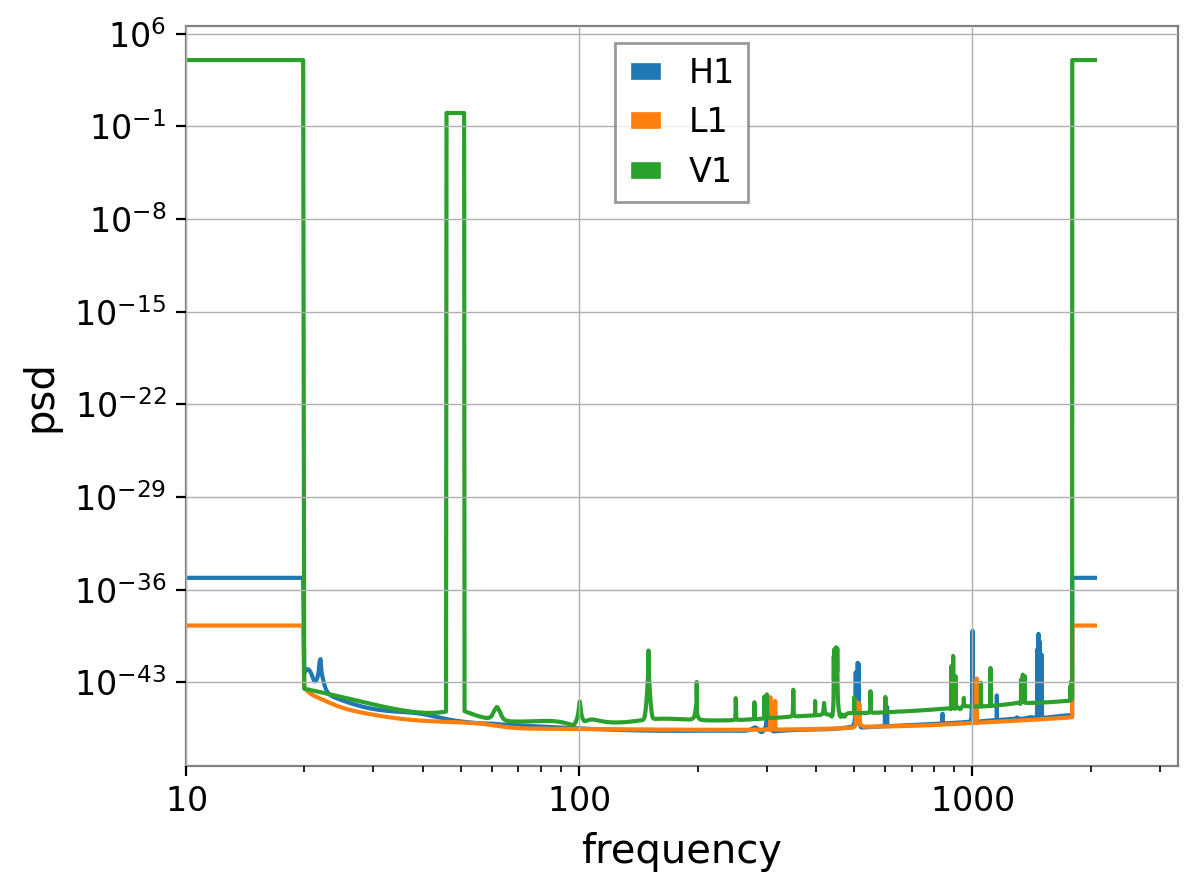

In [3]:
# Plot conditioned PSD
plt.figure()
for i, ifo in enumerate(lm.ifos): 
    freq, psd = lm.conditioned_psd_dict[ifo].transpose()
    plt.loglog(freq, psd, color=f'C{i}', label=ifo)
plt.xlabel('frequency')
plt.ylabel('psd')
plt.legend()
plt.xlim(10,)
plt.show()

### Load FD posterior and get maxL reconstruction

In [4]:
# get reference parameters
FD_posterior = h5ify.load('./input/IGWN-GWTC3p0-v1-GW200208_222617_PEDataRelease_mixed_cosmo.h5')['C01:IMRPhenomXPHM']['posterior_samples']

# get maxL
imax = np.argmax(FD_posterior['log_likelihood'])
reference_parameters_ = FD_posterior[imax]
reference_parameters = {k: reference_parameters_[k] for k in reference_parameters_.dtype.names}

In [5]:
# Get injection
reference_parameters_transformed = run_sampler.modify_parameters(reference_parameters, data['runs']['full']['args'])
injection_dict = lm.waveform_manager.get_projected_waveform(
    reference_parameters_transformed,
    lm.ifos,
    lm.time_dict,
    lm.f22_start, 
    lm.f_ref
)
# Whiten injection
injection_dict_whitened = {ifo : utils.whitenData(
    injection_dict[ifo], 
    lm.time_dict[ifo],
    lm.conditioned_psd_dict[ifo][:, 1], 
    lm.conditioned_psd_dict[ifo][:, 0]
) for ifo in lm.ifos}

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


### Plot strain

In [6]:
# Get detector delay times 
dt_dict = lm.waveform_manager.antenna_and_time_manager.compute_time_delay_dict(
    data['runs']['full']['kwargs']['right_ascension'], 
    data['runs']['full']['kwargs']['declination'], 
    lm.reference_time, 
    lm.ifos
)

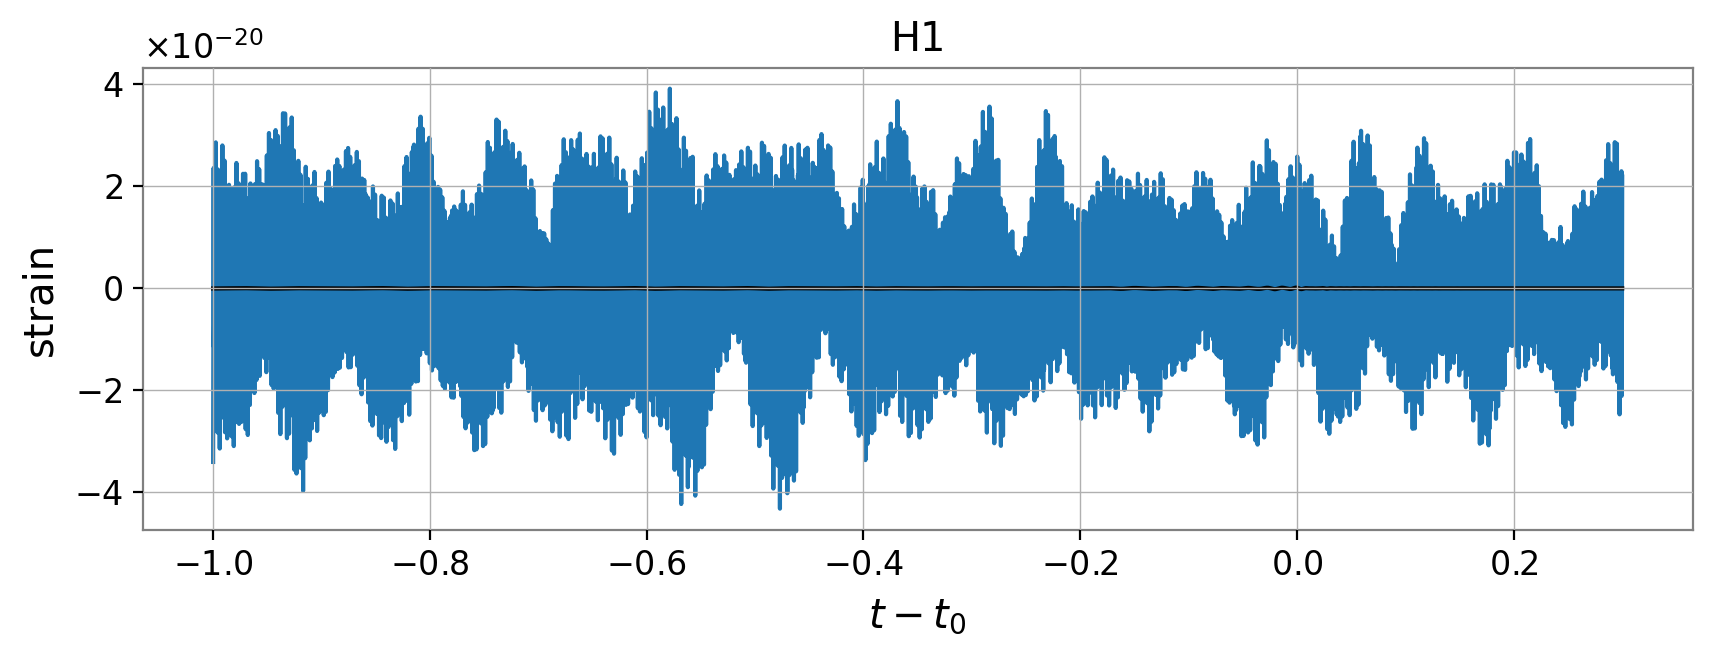

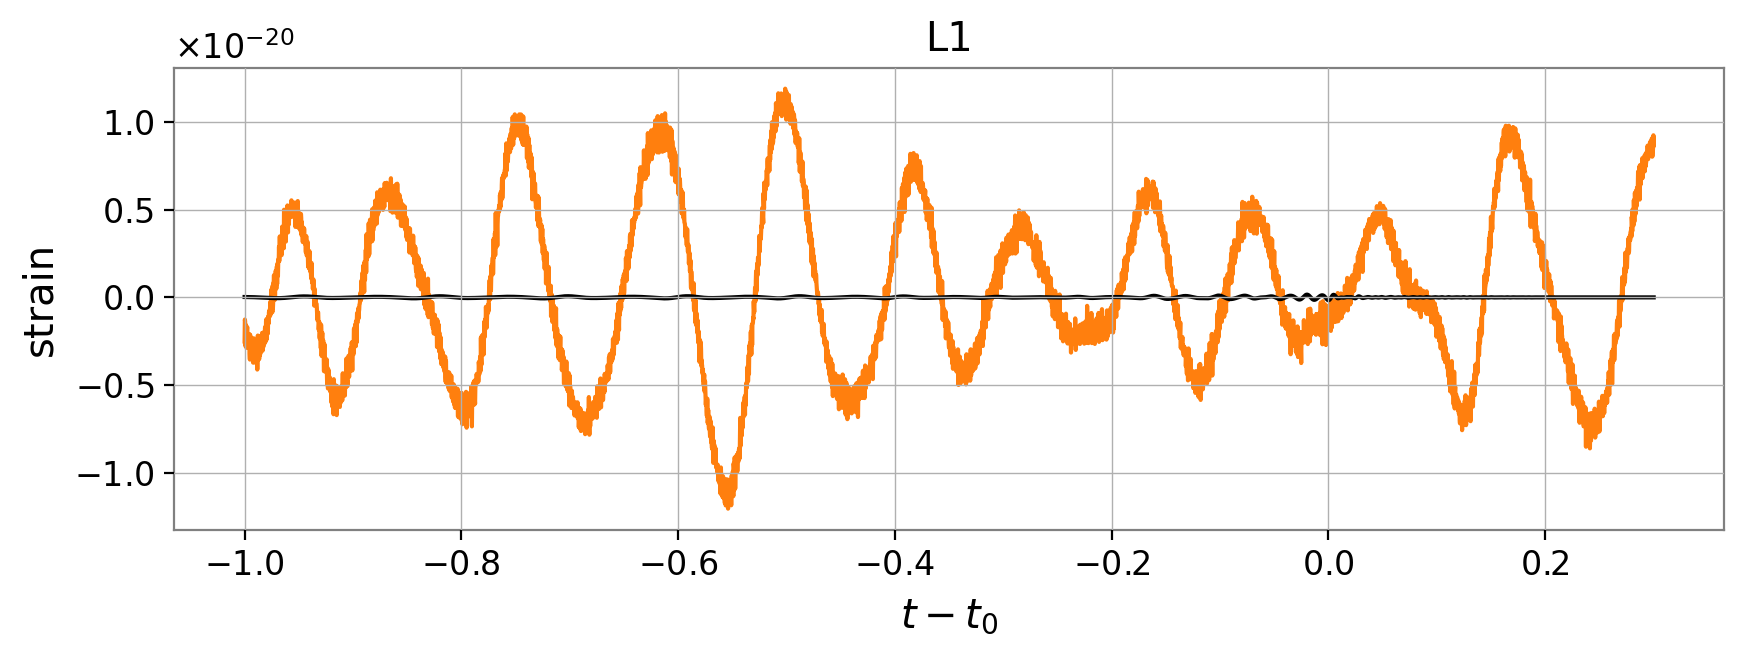

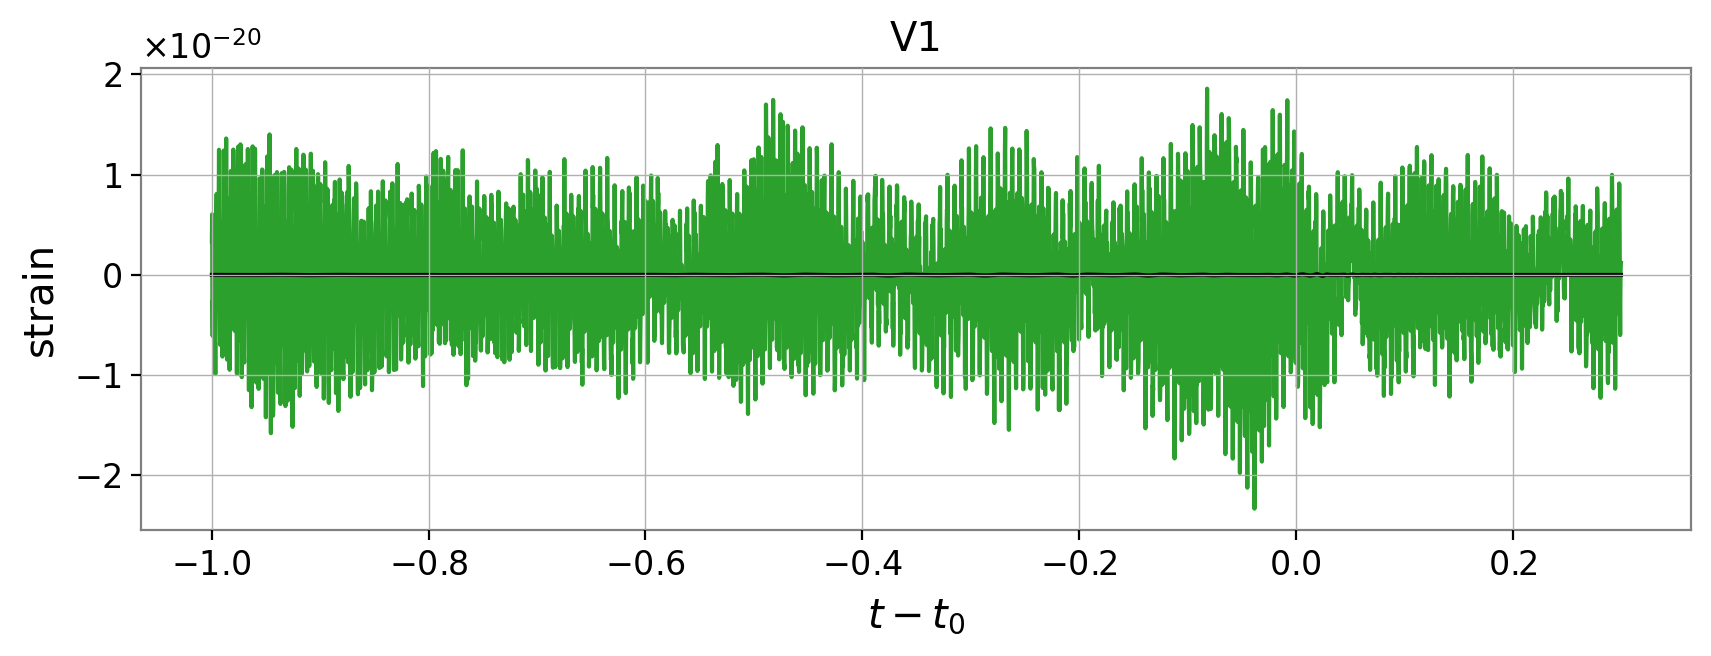

In [7]:
# Colored strain 
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.figure(figsize=(10, 3))
    plt.plot(times, lm.data_dict[ifo], color=f'C{i}')
    plt.plot(times, injection_dict[ifo], color='k')
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('strain')
    plt.show()

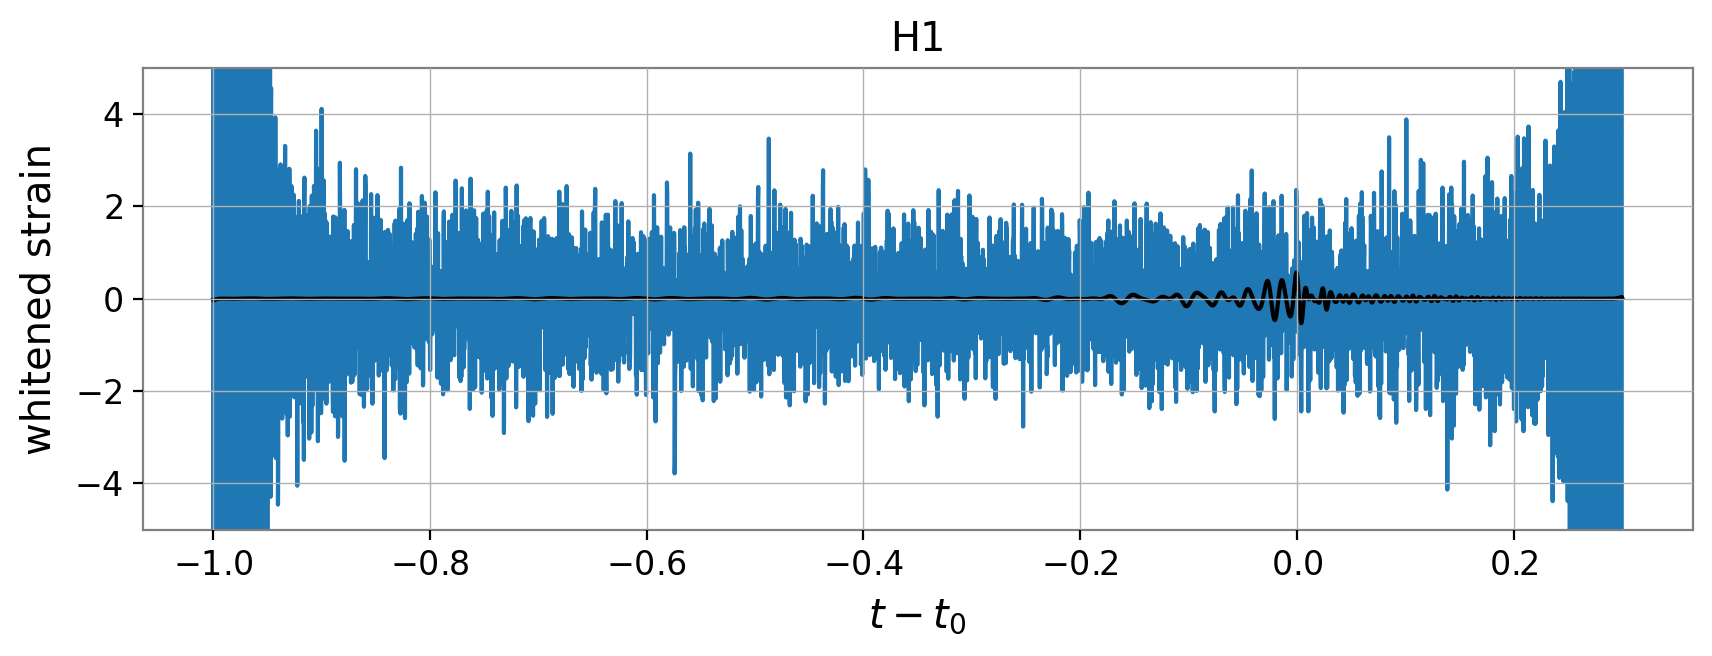

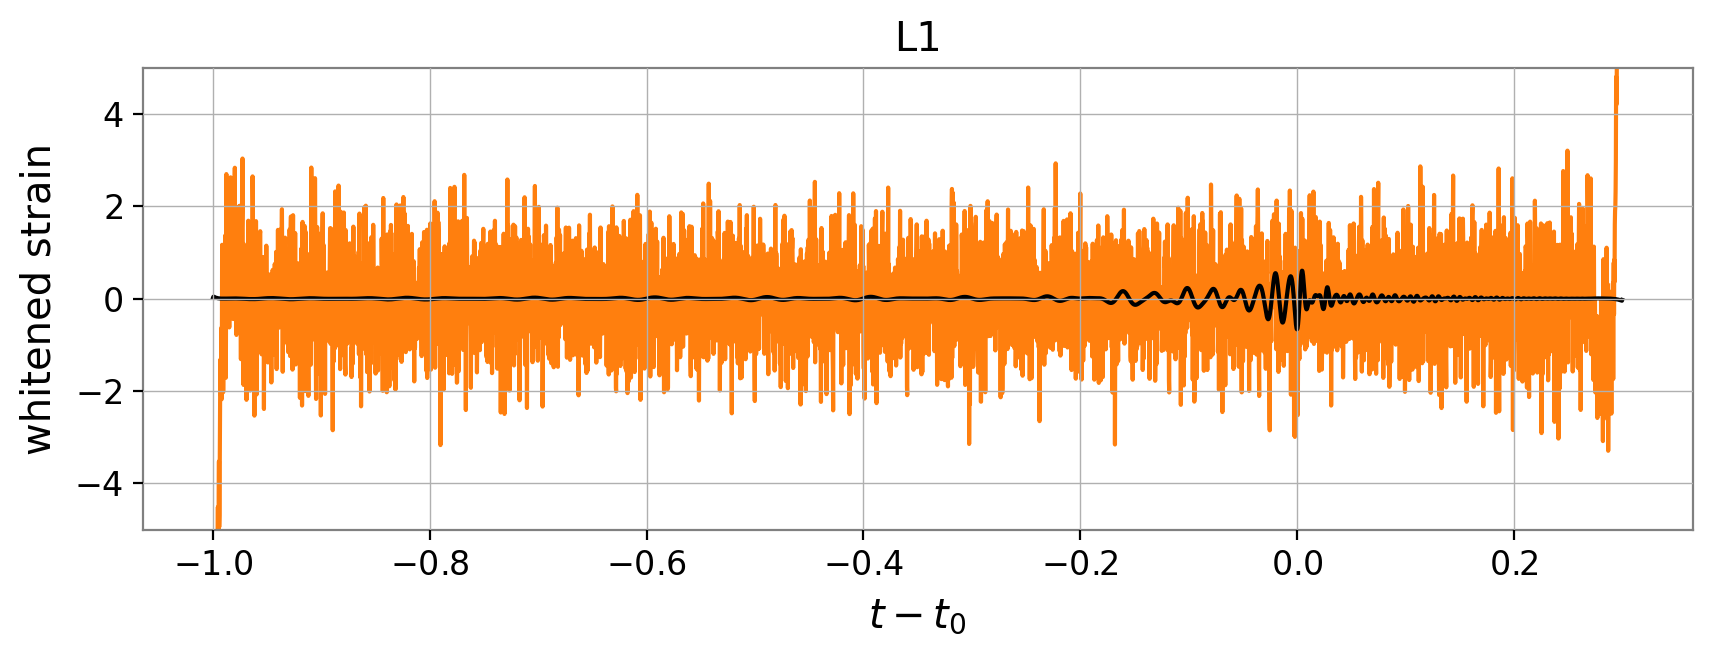

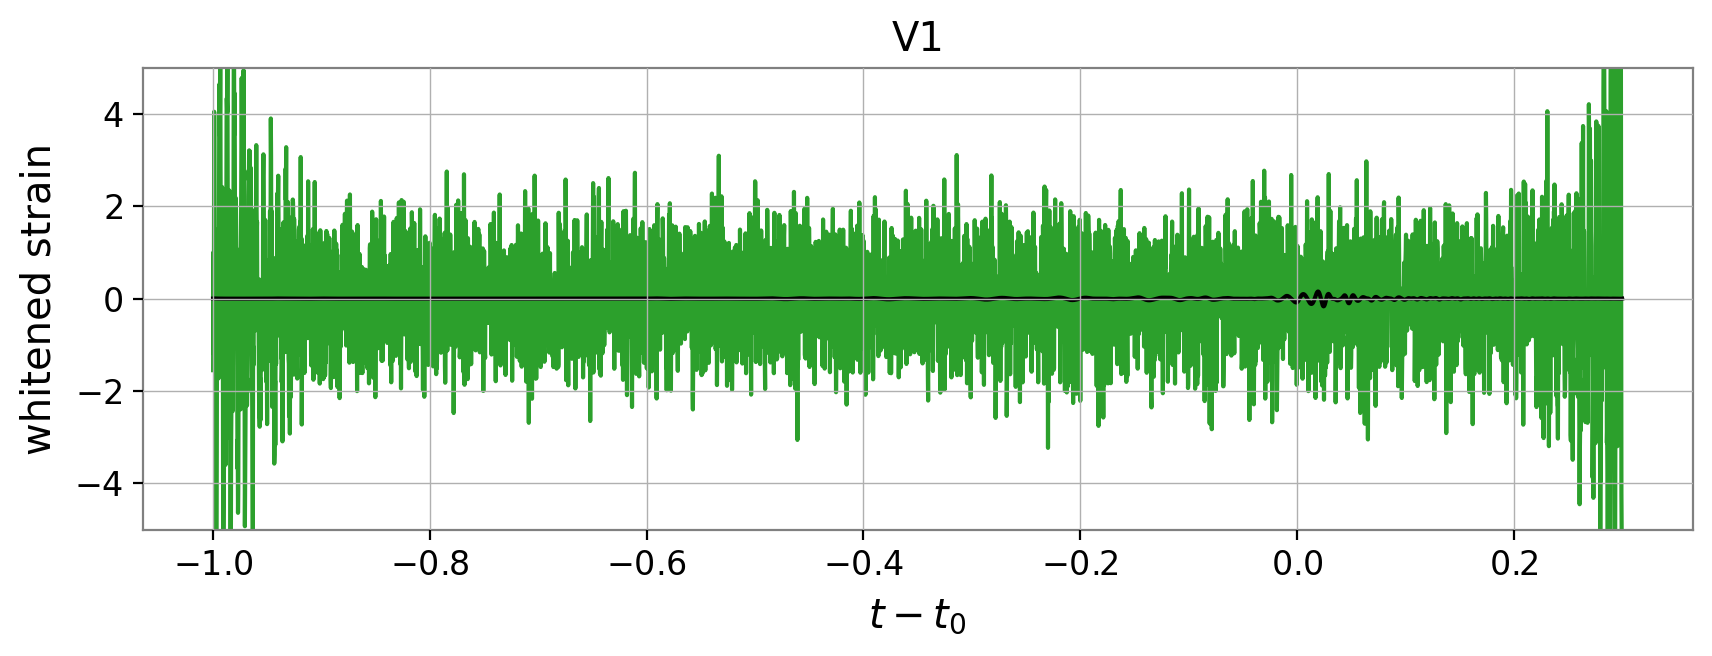

In [8]:
# Whitened strain
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.figure(figsize=(10, 3))
    plt.plot(times, lm.whitened_data_dict[ifo], color=f'C{i}')
    plt.plot(times, injection_dict_whitened[ifo], color='k')
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    plt.ylim(-5,5)
    plt.show()

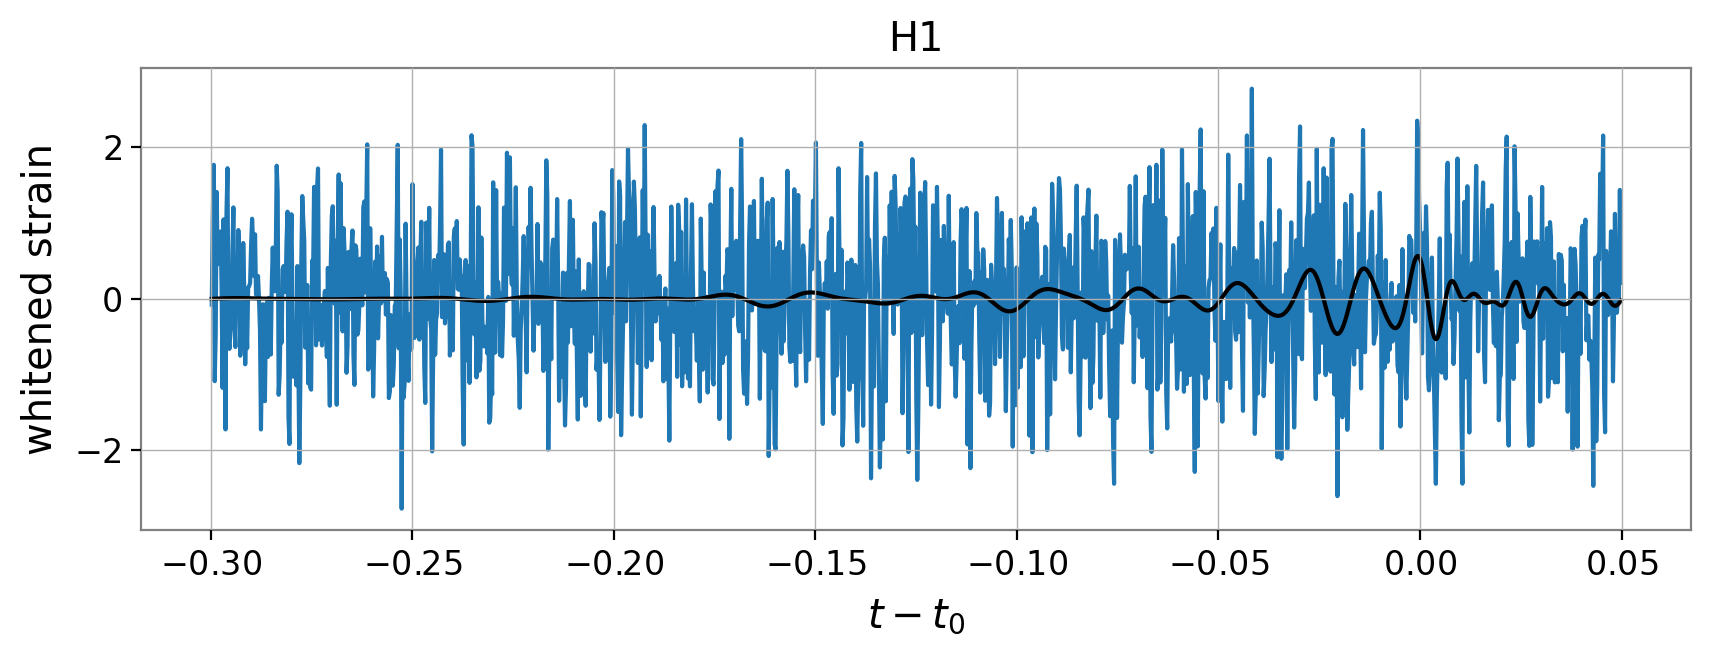

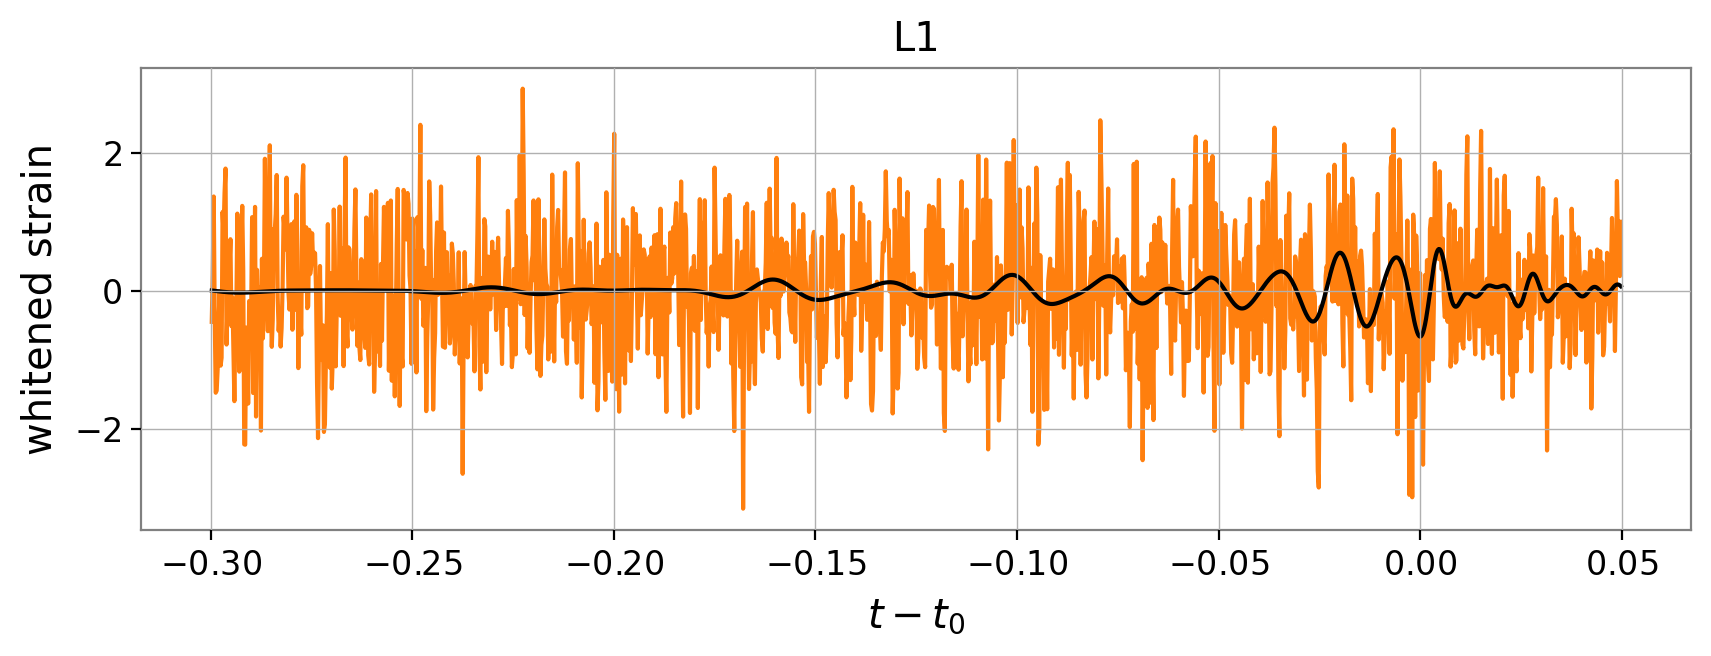

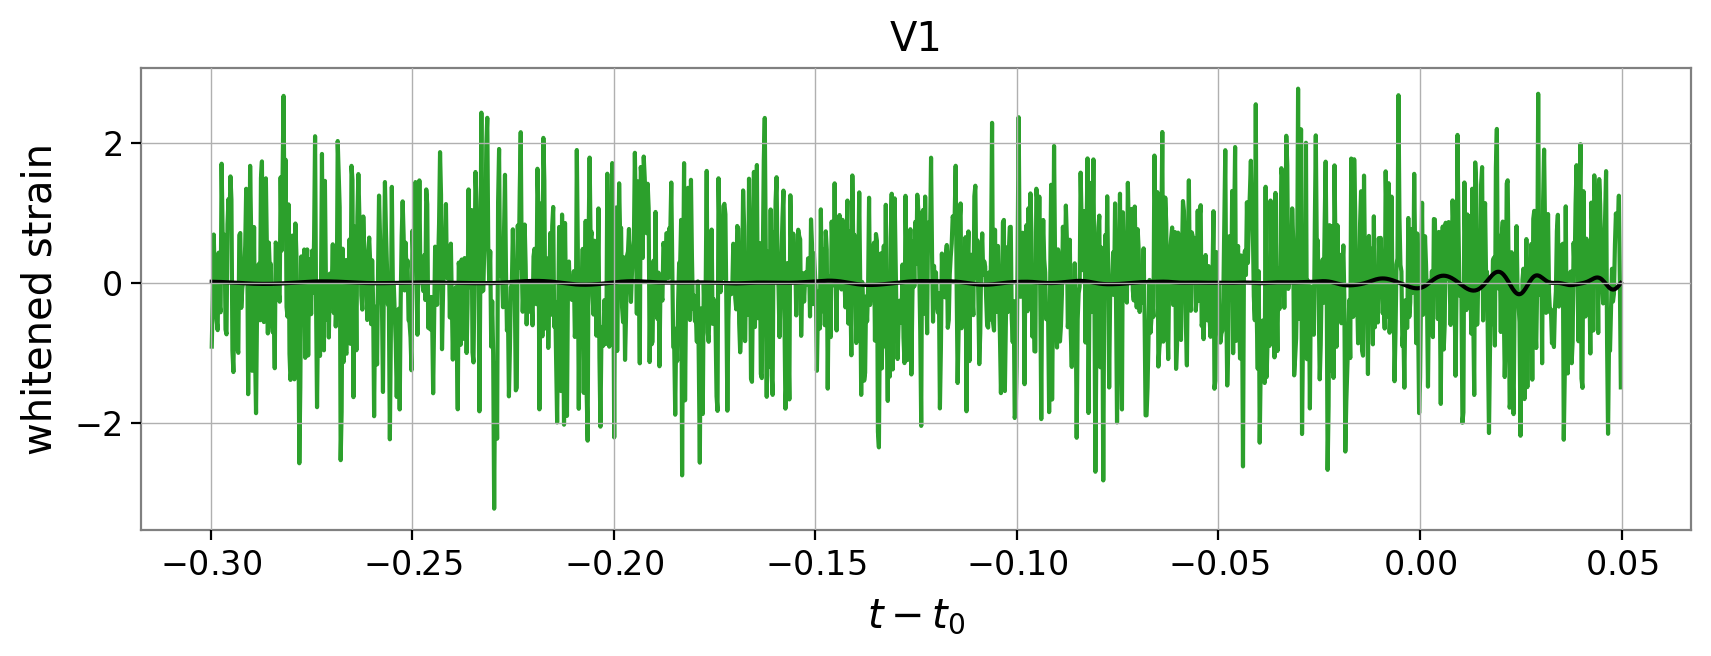

In [9]:
# Whitened strain cropped
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    mask = (times > -0.3) & (times < 0.05)

    plt.figure(figsize=(10, 3))
    plt.plot(times[mask], lm.whitened_data_dict[ifo][mask], color=f'C{i}')
    plt.plot(times[mask], injection_dict_whitened[ifo][mask], color='k')
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    plt.show()

### Cumulative SNR check

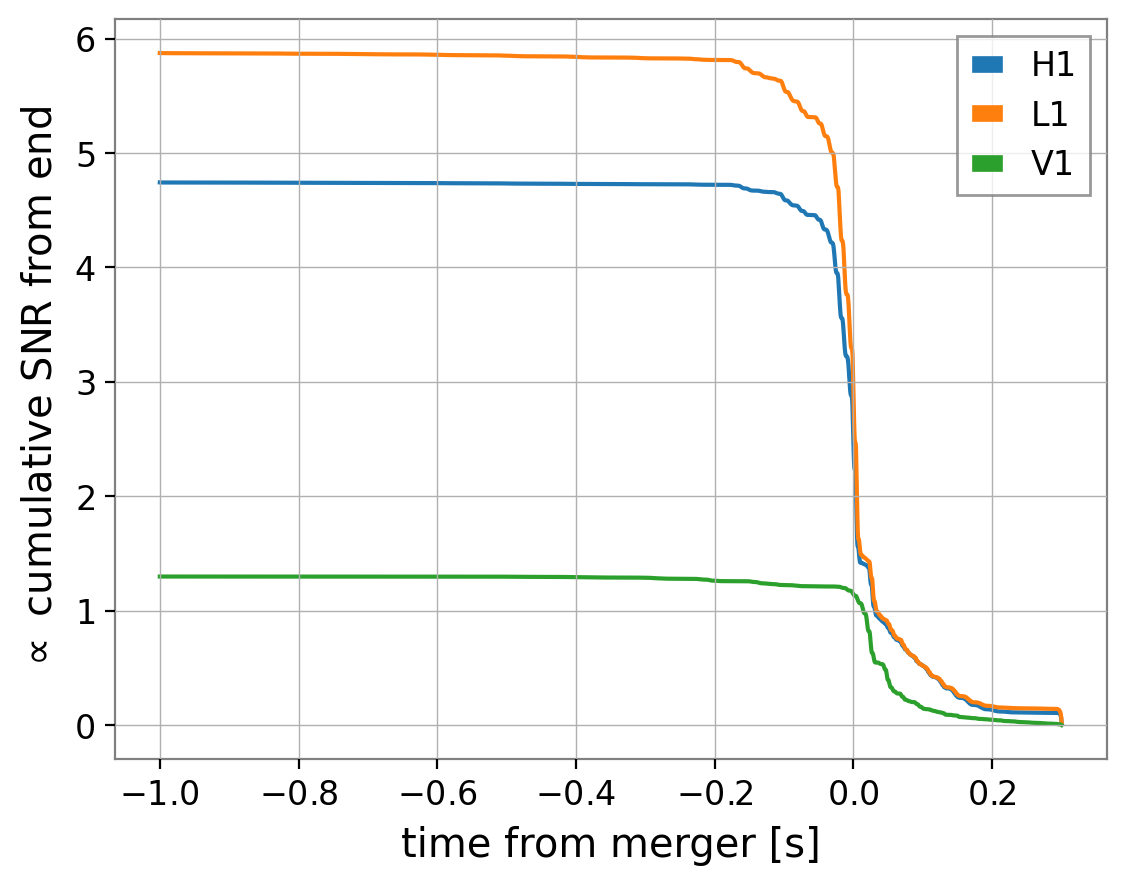

In [10]:
plt.plot()
for ifo in lm.ifos:
    
    times_det = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]
    cum_snr = np.sqrt(np.cumsum(injection_dict_whitened[ifo][::-1]**2))
    
    plt.plot(times_det[::-1], cum_snr, label=ifo)
    
plt.legend()
plt.ylabel('$\propto$ cumulative SNR from end')
plt.xlabel('time from merger [s]')
plt.show()

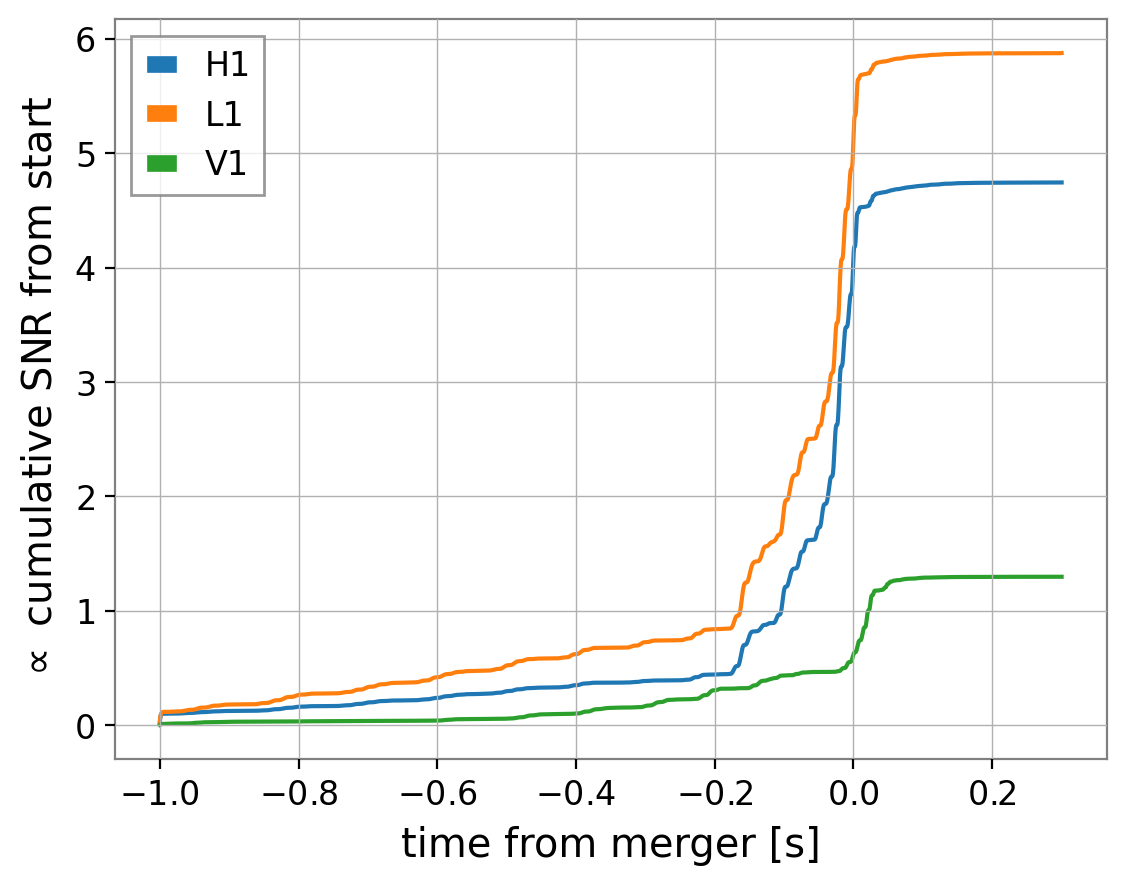

In [11]:
plt.plot()
for ifo in lm.ifos:
    
    times_det = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]
    cum_snr = np.sqrt(np.cumsum(injection_dict_whitened[ifo]**2))
    
    plt.plot(times_det, cum_snr, label=ifo)
    
plt.legend()
plt.ylabel('$\propto$ cumulative SNR from start')
plt.xlabel('time from merger [s]')
plt.show()

In [12]:
print('Tstart =', lm.reference_time - 1)
print('Tend =', lm.reference_time + 0.3)

Tstart = 1265235994.90607
Tend = 1265235996.20607
